In [1]:
!pip install matplotlib==3.6.2
!pip install tensorflow==2.10.1
!pip install opencv-python==4.6.0.66
!pip install imageio==2.23.0
!pip install gdown==4.6.0

     ---------------------------------------- 7.2/7.2 MB 65.1 kB/s eta 0:00:00
     --------------------------------------- 98.3/98.3 kB 98.9 kB/s eta 0:00:00
     ------------------------------------- 160.2/160.2 kB 36.4 kB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-object-detection-api 0.1.1 requires contextlib2, which is not installed.
tensorflow-object-detection-api 0.1.1 requires Cython>=0.28.1, which is not installed.
tensorflow-object-detection-api 0.1.1 requires jupyter, which is not installed.


     -------                               98.3/455.9 MB 140.1 kB/s eta 0:42:32


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\31kus\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\Users\31kus\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\Users\31kus\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\Users\31kus\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\Users\31kus\anaconda3\lib\http\client.py", line 463, in read
    n = self.readinto(b)
  File "C:\Users\31kus\anaconda3\lib\http\client.py", line 507, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\31kus\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\31kus\anaconda3\lib\ssl

     ---------------------------------------- 3.4/3.4 MB 4.9 MB/s eta 0:00:00


# Lip Reading AI

## 0. Import Dependencies

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import matplotlib
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
#prevent exponential growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

## 1. Build Data Loading Functions

In [7]:
import gdown

In [8]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = "data.zip"
# gdown.download(url, output, quiet = False)
gdown.extractall('./data.zip')

['.\\data/',
 '.\\data/alignments/',
 '.\\data/alignments/s1/',
 '.\\data/alignments/s1/bbaf2n.align',
 '.\\data/alignments/s1/bbaf3s.align',
 '.\\data/alignments/s1/bbaf4p.align',
 '.\\data/alignments/s1/bbaf5a.align',
 '.\\data/alignments/s1/bbal6n.align',
 '.\\data/alignments/s1/bbal7s.align',
 '.\\data/alignments/s1/bbal8p.align',
 '.\\data/alignments/s1/bbal9a.align',
 '.\\data/alignments/s1/bbas1s.align',
 '.\\data/alignments/s1/bbas2p.align',
 '.\\data/alignments/s1/bbas3a.align',
 '.\\data/alignments/s1/bbaszn.align',
 '.\\data/alignments/s1/bbaz4n.align',
 '.\\data/alignments/s1/bbaz5s.align',
 '.\\data/alignments/s1/bbaz6p.align',
 '.\\data/alignments/s1/bbaz7a.align',
 '.\\data/alignments/s1/bbbf6n.align',
 '.\\data/alignments/s1/bbbf7s.align',
 '.\\data/alignments/s1/bbbf8p.align',
 '.\\data/alignments/s1/bbbf9a.align',
 '.\\data/alignments/s1/bbbm1s.align',
 '.\\data/alignments/s1/bbbm2p.align',
 '.\\data/alignments/s1/bbbm3a.align',
 '.\\data/alignments/s1/bbbmzn.align',


In [9]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame) # so that we have less data to preprocess
    frames.append(frame[190:236, 80:220, :]) #static slicing of the mouth region
    #mainly isolation of mouth
  cap.release()

  mean = tf.math.reduce_mean(frames) #calc mean
  std  = tf.math.reduce_std(tf.cast(frames,tf.float32)) #calc std deviation
  return tf.cast((frames-mean),tf.float32)/std #return standardised image features

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    oov_token="",
    invert = True)
# out of value token is empty so if it encounters a char that is not in vocab
# it return empty string
print(
    f"The vocaublary is: {char_to_num.get_vocabulary()}"
    f"\nSize = {char_to_num.vocabulary_size()}"
)

The vocaublary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
Size = 40


In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [22]:
def load_data(path:str):
  path = bytes.decode(path.numpy())
  # File name splitting for Linux and Colab
#   file_name = path.split('/')[-1].split('.')[0] #get bbf2an from path->bbf2an.mpg->bbf2an
  # File name splitting for windows
  file_name = path.split('\\')[-1].split('.')[0]

  # TO BE USED WHEN DATA IS DIRECTLY UPLOADED IN THE SAME PATH
  video_path = os.path.join('data','s1',f'{file_name}.mpg')
  alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
  
  # /content/drive/MyDrive/Colab data/Lip Reading AI/data
#   video_path = os.path.join('drive','MyDrive','Colab data','Lip Reading AI','data','s1',f'{file_name}.mpg')
#   alignment_path = os.path.join('drive','MyDrive','Colab data','Lip Reading AI','data','alignments','s1',f'{file_name}.align')
  frames = load_video(video_path) 
  alignments = load_alignments(alignment_path)
  
  return frames, alignments

In [26]:
test_path =  os.path.join('data','s1','bras9a.mpg')

In [27]:
tf.convert_to_tensor(test_path).numpy().decode('UTF-8').split('/')[-1].split('.')[0]

'data\\s1\\bras9a'

In [28]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

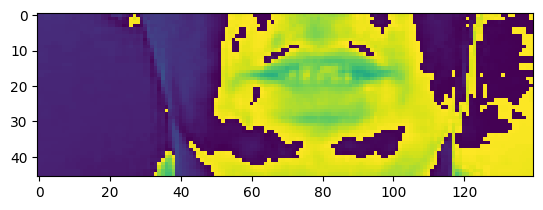

In [29]:
imgplot = plt.imshow(frames[45])

In [30]:
alignments

<tf.Tensor: shape=(23,), dtype=int64, numpy=
array([ 2,  9, 14, 39, 18,  5,  4, 39,  1, 20, 39, 19, 39, 14,  9, 14,  5,
       39,  1,  7,  1,  9, 14], dtype=int64)>

In [31]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>

In [32]:
# if we wanna use pure string processing we need to wrap it in tf.py_function
# helps in tensorflow data pipelining
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## 2. Create Data Pipeline


In [36]:
data = tf.data.Dataset.list_files('data\\s1\\*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
# 1 batch -> 2 videos and their aligns -> 75 frames per video and 40 tokens per align
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) 
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [37]:
frames,alignments = (data.as_numpy_iterator().next())

In [38]:
len(frames)

2

In [40]:
test_data = data.as_numpy_iterator().next()
val = test_data

In [41]:
imageio.mimsave('./animation.gif',val[0][1 ],fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.210616111755371]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

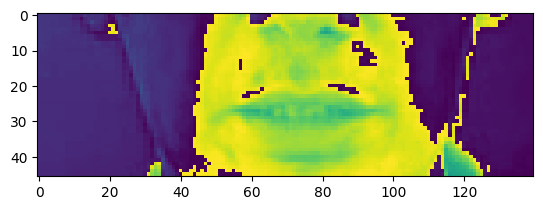

In [42]:
# 0:videos (from videos or aligns) , 1:2nd video, 45:45th frame of the 2nd video
plt.imshow(val[0][1][45])

## 3. Design the Deep Neural Network

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [44]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [45]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal',return_sequences=True )))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

# dense layer is 1+sz to handle the special 
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [47]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [48]:
yhat[0].shape

(75, 41)

In [49]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([31, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17,  5,  5], dtype=int64)>

In [50]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'2qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqee'>

In [51]:
model.input_shape

(None, 75, 46, 140, 1)

In [52]:
model.output_shape

(None, 75, 41)

## 4. Setup Training Options and Train

In [53]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [54]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [55]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [56]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = CTCLoss)

In [57]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss',save_weights_only=True)

In [58]:
schedule_callback = LearningRateScheduler(scheduler)

In [59]:
example_callback = ProduceExample(data)

In [60]:
model.fit(train, validation_data=test, epochs=2, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/2


KeyboardInterrupt: 

## 5. Make a Prediction

In [67]:
gdown.extractall('./models/checkpoint.zip')

['./models\\checkpoint.index',
 './models\\__MACOSX/._checkpoint.index',
 './models\\checkpoint.data-00000-of-00001',
 './models\\__MACOSX/._checkpoint.data-00000-of-00001',
 './models\\checkpoint',
 './models\\__MACOSX/._checkpoint']

In [72]:
model.load_weights("./models\\checkpoint")

In [93]:
test_data = test.as_numpy_iterator()

In [94]:
sample = test_data.next()

In [95]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


In [96]:
print( '~'*40, 'REAL TEXT','~'*40)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z five soon'>]

In [97]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [98]:
print( '~'*40, 'PREDICTIONS','~'*40)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z five soon'>]

## 6. Testing on sample video

In [84]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [85]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [86]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 3s 3s/step


In [87]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [89]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]